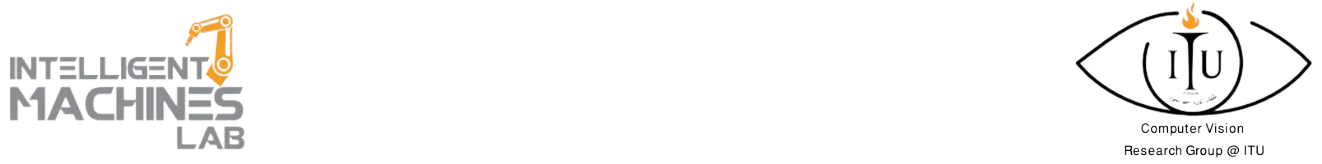

## Generative AI & LLM Fall 2024
## Assignment 2: Implementing a VAE using CNN and pytorch

In this assignment, you will implement a VAE using CNN and pytorch. You will use the MNIST dataset for this assignment.

**You will need to implement the following:**

1. The VAE Model
2. Kaiming Initialization also known as He Initialization (https://paperswithcode.com/method/he-initialization)
3. The VAE loss function
4. The forward pass
5. The training loop
6. The evaluation loop
7. The sampling loop
8. Visualize the latent space


**Guidelines:**

1. Use this notebook as a template to implement the VAE model.
2. Try your best to avoid using ChatGPT or any other LLM to complete this assignment.
3. If you get stuck, please reach out at `manzoor.rohan97@gmail.com`
4. Ensure proper formatting of the code.
5. While you will be implementing the assignment on Colab, you are also required to upload the project to github and share the link with us.


**The assignment will be evaluated based on the following criteria:**

| Criteria                | Marks |
|-------------------------|-------|
| 1. VAE model            | 2.5   |
| 2. Training Loop        | 2.5   |
| 3. Correct Sampling     | 2.0   |
| 4. Viva                 | 3.0   |
| Total                   | 10.0  |


Name: `Hassan Raza`

Reg No: `MSCS24012`

Github Link: `your github link here`

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms,datasets
from torch.utils.data import DataLoader
import torch.optim as optim


# Model Definition

In [3]:
class CNN_VAE(nn.Module):
    def __init__(self, input_channels, latent_dims,h_dims=[32, 64]):
        super(CNN_VAE, self).__init__()
        # Encoder Convolutional layer
        self.conv1 = nn.Conv2d(in_channels=input_channels,out_channels=h_dims[0],kernel_size=3,stride=2,padding=1) # 15*15
        self.conv2 = nn.Conv2d(in_channels=h_dims[0],out_channels= h_dims[1],kernel_size=3,stride=2,padding=1) # 8*8
        # Encoder Fully Connected layer
        self.fc1 = nn.Linear(64*7*7,120)
        self.fc2 = nn.Linear(120,100)

        # Mean and the log_var fully Connected layers
        self.fc_mean = nn.Linear(100,latent_dims)
        self.fc_logvar = nn.Linear(100,latent_dims)

        # Decoder Fully Convolutional layer
        self.tconv_1 = nn.ConvTranspose2d(h_dims[1],h_dims[0],kernel_size=3,stride=2,padding=1,output_padding=1)
        self.tconv_2 = nn.ConvTranspose2d(h_dims[0],input_channels,kernel_size=3,stride=2,padding=1,output_padding=1)
        # Decoder Fully Connected layer
        self.d_fc_1 = nn.Linear(latent_dims,100)
        self.d_fc_2 = nn.Linear(100,64*7*7)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu+eps*std
        return z


    def encode(self, x):
        x = (self.conv1(x))
        x = nn.ReLU()(x)
        x = (self.conv2(x))
        x = nn.ReLU()(x)
        x  = x.view(x.size(0),-1) # flatten my image
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        mu = self.fc_mean(x)
        logvar = self.fc_logvar(x)        
        return mu, logvar

    def decode(self, z):
        z = self.d_fc_1(z)
        z = nn.ReLU()(z)
        z = self.d_fc_2(z)
        z = z.view(-1,64,7,7)
        x_constructed = self.tconv_1(z)
        x_constructed = nn.ReLU()(x_constructed)
        x_constructed = self.tconv_2(x_constructed)
        return x_constructed
    


    def forward(self, x):
        mu,logvar = self.encode(x)
        z = self.reparametrize(mu,logvar)
        x_constructed = self.decode(z)
        x_constructed = nn.Sigmoid()(x_constructed)
        x = nn.ReLU()(x)
        return x_constructed,mu,logvar,x

# Usage
INPUT_CHANNELS = 1
INPUT_SIZE = 28
latent_dims=2
BATCH_SIZE = 100
X = torch.randn((BATCH_SIZE, INPUT_CHANNELS, INPUT_SIZE, INPUT_SIZE))
X = nn.ReLU()(X)
model = CNN_VAE(input_channels=INPUT_CHANNELS,latent_dims=latent_dims)
x_constructed, mu, logvar,x = model.forward(torch.randn((BATCH_SIZE, INPUT_CHANNELS, INPUT_SIZE, INPUT_SIZE)))
print(mu)

tensor([[ 0.0482, -0.0694],
        [ 0.0367, -0.0510],
        [ 0.0384, -0.0428],
        [ 0.0263, -0.0568],
        [ 0.0379, -0.0592],
        [ 0.0435, -0.0587],
        [ 0.0464, -0.0655],
        [ 0.0560, -0.0485],
        [ 0.0358, -0.0399],
        [ 0.0191, -0.0494],
        [ 0.0451, -0.0673],
        [ 0.0471, -0.0502],
        [ 0.0406, -0.0636],
        [ 0.0341, -0.0702],
        [ 0.0372, -0.0346],
        [ 0.0578, -0.0573],
        [ 0.0453, -0.0575],
        [ 0.0394, -0.0629],
        [ 0.0282, -0.0513],
        [ 0.0355, -0.0522],
        [ 0.0409, -0.0592],
        [ 0.0492, -0.0566],
        [ 0.0341, -0.0547],
        [ 0.0308, -0.0601],
        [ 0.0465, -0.0424],
        [ 0.0285, -0.0693],
        [ 0.0342, -0.0654],
        [ 0.0500, -0.0653],
        [ 0.0436, -0.0514],
        [ 0.0463, -0.0583],
        [ 0.0423, -0.0528],
        [ 0.0329, -0.0477],
        [ 0.0420, -0.0667],
        [ 0.0335, -0.0697],
        [ 0.0346, -0.0551],
        [ 0.0389, -0

# Dataset Loading

In [3]:
# Hyper-parameters
# you can change these to see how the model performs
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
INPUT_DIMS = 1
HID_DIMS = [32, 64]
Z_DIMS = 20
NUM_EPOCHS = 10
LR = 3e-4
BATCH_SIZE = 64
VAL_AFTER = 800
for i in range(NUM_EPOCHS):
    model = CNN_VAE(input_channels=INPUT_CHANNELS,latent_dims=latent_dims)
    output, mu, logvar,x = model.forward(torch.randn((BATCH_SIZE, INPUT_CHANNELS, INPUT_SIZE, INPUT_SIZE)))


In [4]:

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL Image to Tensor and scales [0, 255] to [0.0, 1.0]
    # No need to add channel dimension as ToTensor() handles it for standard datasets
])

# Load your dataset (MNIST)
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Create a DataLoader
batch_size = 100  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Fetch the first batch
test_images, test_labels = next(iter(test_loader))  # all_images shape: [100, 1, 28, 28]
train_images, train_labels = next(iter(train_loader))


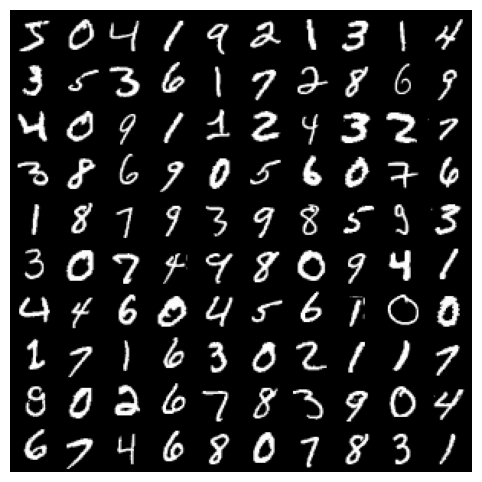

In [5]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
def plot_image(img, nrow=10):
    plt.figure(figsize=(10, 6))
    plt.imshow(make_grid(img, nrow=nrow).permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()
instance = plot_image(train_images)

# Training Loop

In [6]:
INPUT_CHANNELS = 1
INPUT_SIZE = 28
latent_dims=2
BATCH_SIZE = 100
model = CNN_VAE(input_channels=INPUT_CHANNELS,latent_dims=latent_dims)
x_constructed, mu, logvar,x = model.forward(train_images)
# Define VAE loss
def vae_loss(reconstructed_x, x, mu, logvar):
    # Correct order: (predicted, target)
    bce = nn.functional.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD + bce
loss = vae_loss(x_constructed,train_images,mu,logvar)


In [7]:
from tqdm import tqdm

# Instructions:
# 1. Initialize the model and the optimizer. You will be using Adam optimizer
# 2. Implement a training loop that iterates over the training data, performs forward and backward passes, and updates the model parameters.
# 3. Implement a validation loop that evaluates the model on the validation data.
# 4. Implement a progress bar to visualize the training progress.
# 5. Store your training and validation losses in train_losses and eval_losses respectively.

INPUT_CHANNELS = train_images.shape[1]
INPUT_SIZE = train_images.shape[2]
latent_dims=2
BATCH_SIZE = 100
model = CNN_VAE(input_channels=INPUT_CHANNELS,latent_dims=latent_dims,h_dims=[32, 64])
x_constructed, mu, logvar,x = model.forward(train_images)
optimizer = optim.Adam(model.parameters(),lr=3e-4)
NUM_EPOCHS = 50
train_losses = []
eval_losses = [] 
# for epoch in range(NUM_EPOCHS):
#     for batch_idx, (data, _) in enumerate(train_loader):
#         data = data.to(DEVICE)  # Move data to GPU if available
#         optimizer.zero_grad()  # Clear gradients

#         # Forward pass
#         reconstructed, mu, logvar,x = model(data)

#         # Compute loss
#         loss = vae_loss(reconstructed, data, mu, logvar)

#         # Backward pass
#         loss.backward()
#         optimizer.step()  # Update model parameters


#     # TODO: Implement the training loop
import matplotlib.pyplot as plt
from tqdm import tqdm

INPUT_CHANNELS = train_images.shape[1]
latent_dims = 2
BATCH_SIZE = 100
model = CNN_VAE(input_channels=INPUT_CHANNELS, latent_dims=latent_dims, h_dims=[32, 64])
optimizer = optim.Adam(model.parameters(), lr=3e-4)
train_losses = []
eval_losses = [] 

# Training Loop
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)  # Move data to GPU if available
        optimizer.zero_grad()  # Clear gradients

        # Forward pass
        reconstructed, mu, logvar, x = model(data)

        # Compute loss
        train_loss = vae_loss(reconstructed, data, mu, logvar)

        # Backward pass
        train_loss.backward()
        optimizer.step()  # Update model parameters
        
        total_train_loss += train_loss.item()  # Accumulate loss for averaging

    # Append average training loss for the epoch
    train_losses.append(total_train_loss / len(train_loader))  # Average loss over all batches

    # Start of the Evaluation Loop
    model.eval()
    total_eval_loss = 0  # Initialize the total evaluation loss for the epoch
    with torch.no_grad():  # No gradients needed for evaluation
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(DEVICE)  # Move data to GPU if available
            
            # Forward pass
            reconstructed, mu, logvar, x = model(data)

            # Compute loss
            eval_loss = vae_loss(reconstructed, data, mu, logvar)
            total_eval_loss += eval_loss.item()  # Accumulate loss for averaging

    # Append average evaluation loss for the epoch
    eval_losses.append(total_eval_loss / len(test_loader))  # Average loss over all batches


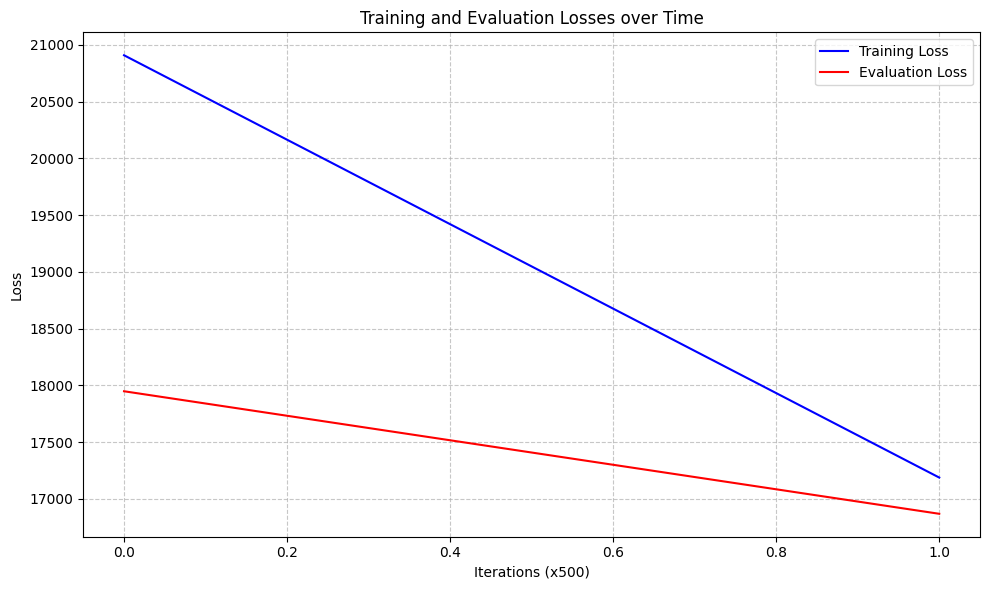

In [8]:
# Visualize your losses as your training progresses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(eval_losses, label='Evaluation Loss', color='red')
plt.title('Training and Evaluation Losses over Time')
plt.xlabel('Iterations (x500)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Visualizations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


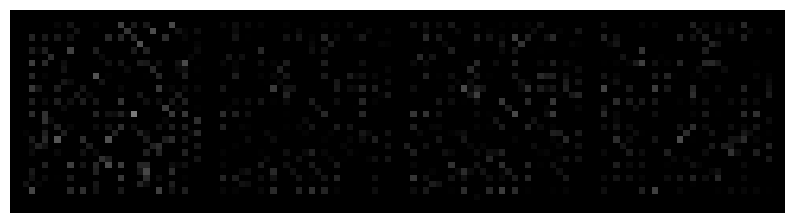

In [9]:
# for batch_idx,(data,labels) in enumerate(train_loader):
#     digit = 9
#     mask = labels==digit
#     filter_images = data[mask]
# print(len(filter_images))
# digit = 9
# d_images = []
# for images,labels in train_loader:
#     mask = labels==digit
#     filter_images = images[mask]
#     d_images.append(filter_images)
# print(len(d_images))

def visualize_generations(model, digit, num_examples):
    d_images = []
    for images,labels in train_loader:
        mask = labels==digit
        filter_images = images[mask]
        d_images.append(filter_images)
    d_images = torch.cat(d_images, dim=0)
    # Encode the images
    mu,logvar = model.encode(d_images)
    # Latent space
    z = model.reparametrize(mu,logvar)
    # Decode from the latent space
    x_cons = model.decode(z)
    model.eval()
    with torch.no_grad():
        x_constructed,mu,logvar,x = model.forward(d_images)
    wanted_images = x_constructed[:num_examples]

    return x_cons[:num_examples],d_images[:num_examples]
BATCH_SIZE=1
INPUT_CHANNELS=1
INPUT_SIZE=28
INPUT_SIZE=28
model = CNN_VAE(1,2)
digit = 9
num_examples = 4
x_constructed,d_images = visualize_generations(model,digit,num_examples)
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
instance = plot_image(x_constructed)
    # TODO: Implement the visualize_generations function
    # You will first encode the digit images into their latent space encodings
    # Then you will sample from the latent space and decode the samples to get the reconstructed images
    # You will then plot the reconstructed images
    # Use the plot_image function to plot the images




# digit = 9
# num_examples = 4

#generate_samples(model, digit, num_examples)

In [10]:
def visualize_latens(dataloader, model):
    encoded_test_images = model.encode(dataloader)
    x_constructed, mu, logvar,x = model.forward(dataloader)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        mu[:, 0],          
        mu[:, 1],          
        c=test_labels,              
        cmap='tab10',          
        alpha=0.7,             
        edgecolor='k',         
        s=40                   
    )
    cbar = plt.colorbar(scatter, ticks=range(10))
    cbar.set_label('Digit Label', rotation=270, labelpad=15)
    cbar.set_ticks(range(10))
    cbar.set_ticklabels(range(10))
    plt.title('2D Latent Space of MNIST Test Data (VAE)', fontsize=16)
    plt.xlabel('Latent Dimension 1', fontsize=14)
    plt.ylabel('Latent Dimension 2', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

instance_of_visualize_latens = visualize_latens(train_images,model)   


